In [237]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, auc, RocCurveDisplay,  silhouette_score, classification_report, accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub


## 1. data load

In [238]:
df = pd.read_csv("/Users/yj.noh/Desktop/on_boarding_data.csv", encoding = "cp949")
print(df.head(2))
print(df.isna().sum())

                                       brms_rider_id  birth delivery_method  \
0  026B06CB0AC03ABA7813A3C8DD76D95B702571BABA6A81...   1990             CAR   
1  136D981F6187D2EEC6E9AB9F73FFB999B8184E7D3A2E3B...   1980    PAS_BICYCLES   

  insurance_type first_available_date business_start_day  is_recom gender  \
0  CAR_ON_DEMAND           2023-08-16         2023-08-16         0    MAN   
1  ETC_ON_DEMAND           2021-09-28         2023-08-13         0    MAN   

   day_cnt  avg_cnt last_working_day  outcome  
0        2      6.5       2023-08-21        1  
1        7      8.0       2023-10-24        0  
brms_rider_id           0
birth                   0
delivery_method         0
insurance_type          0
first_available_date    0
business_start_day      0
is_recom                0
gender                  0
day_cnt                 0
avg_cnt                 0
last_working_day        0
outcome                 0
dtype: int64


In [239]:
#data_filter = df[((df['day_cnt'].notnull()) & (df['delivery_method'] == 'BIKE') & (df['is_recom'] == 0))]
data_filter = df[((df['day_cnt'].notnull()) & (df['delivery_method'] == 'BIKE'))]
#data_filter =  df[df['day_cnt'].notnull()]   

print(data_filter.isna().sum())
print(data_filter.shape) # 7,940

brms_rider_id           0
birth                   0
delivery_method         0
insurance_type          0
first_available_date    0
business_start_day      0
is_recom                0
gender                  0
day_cnt                 0
avg_cnt                 0
last_working_day        0
outcome                 0
dtype: int64
(3421, 12)


In [240]:
print(data_filter['outcome'].value_counts()) 

outcome
0    2255
1    1166
Name: count, dtype: int64


# 2. boxplot 

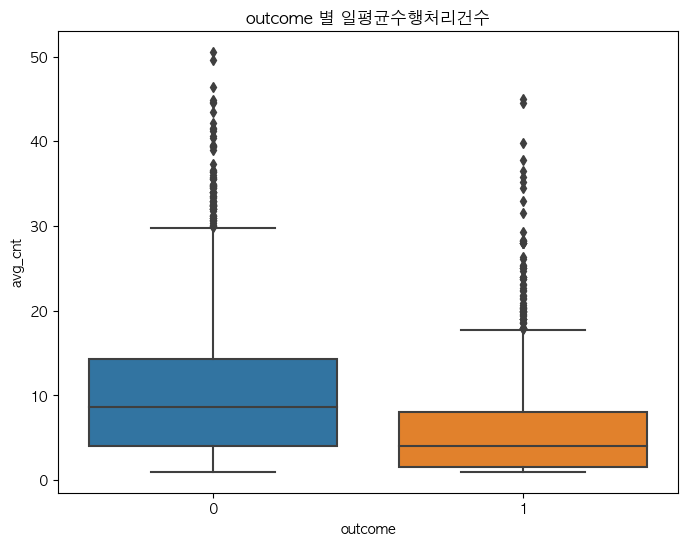

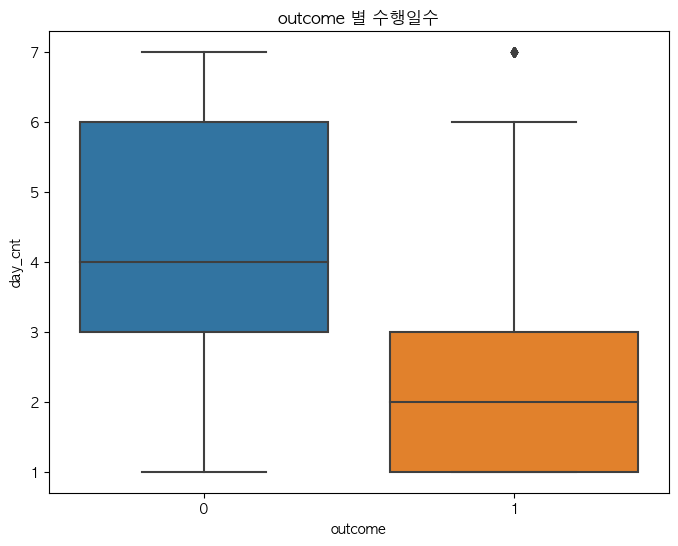

In [241]:
plt.figure(figsize=(8,6))
sns.boxplot(data=data_filter, x='outcome', y='avg_cnt')
plt.title("outcome 별 일평균수행처리건수")
plt.savefig("prj_on_boarding/boxplot1.png")
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(data=data_filter, x='outcome', y='day_cnt')
plt.title("outcome 별 수행일수")
plt.savefig("prj_on_boarding/boxplot2.png")
plt.show()

In [242]:
# outlier 제거 
def remove_outliers(df, column):
    Q1 = df.groupby('outcome')[column].quantile(0.25)
    Q3 = df.groupby('outcome')[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[df.apply(lambda x: (x[column] >= lower_bound[x['outcome']]) & 
                                 (x[column] <= upper_bound[x['outcome']]), axis=1)]

# 'avg_cnt'와 'day_cnt'에 대한 아웃라이어 제거
data_filtered_avg = remove_outliers(data_filter, 'avg_cnt')
data_filtered_both = remove_outliers(data_filtered_avg, 'day_cnt')

print(data_filtered_both.shape)  #3,257


(3257, 12)


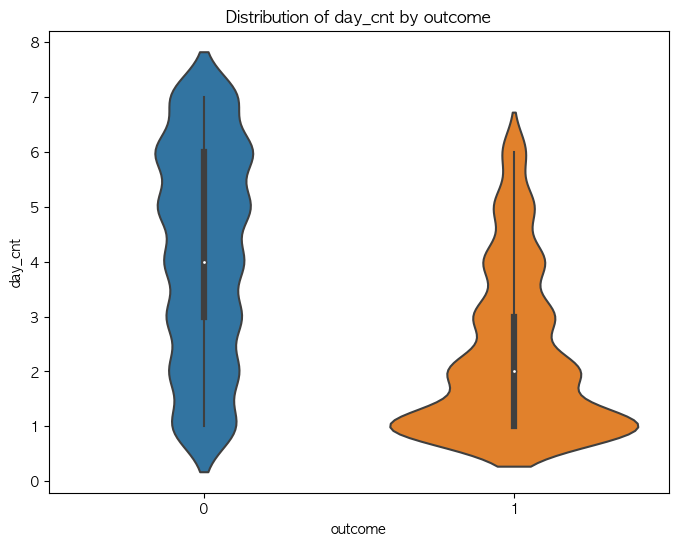

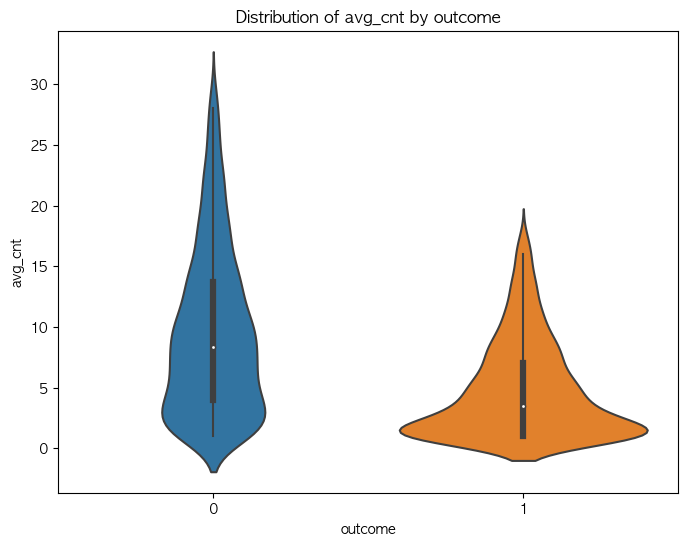

In [243]:
# day_cnt
plt.figure(figsize=(8,6))
sns.violinplot(x='outcome', y='day_cnt', data=data_filtered_both)
plt.title('Distribution of day_cnt by outcome')
plt.show()

# avg_cnt
plt.figure(figsize=(8,6))
sns.violinplot(x='outcome', y='avg_cnt', data=data_filtered_both)
plt.title('Distribution of avg_cnt by outcome')
plt.show()


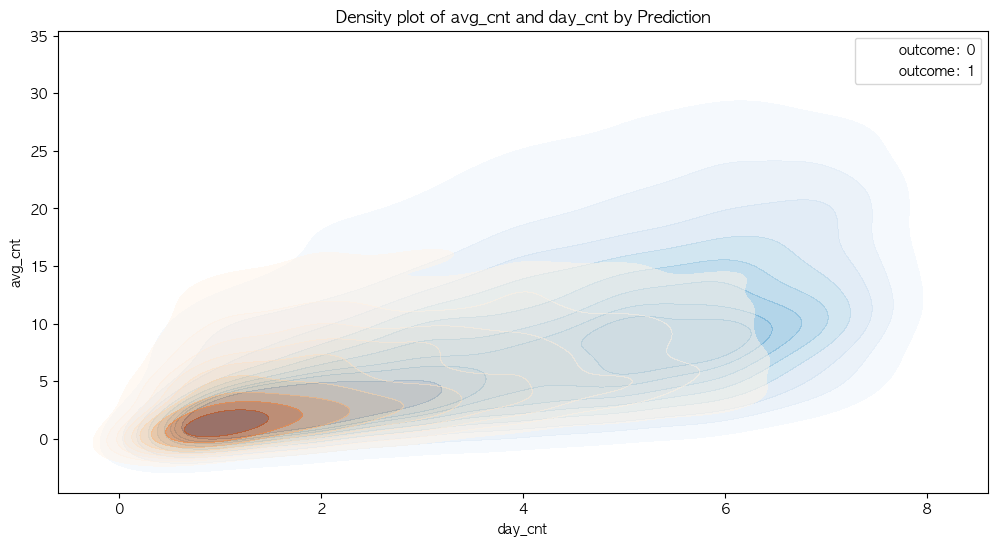

In [244]:
# 데이터 필터링
X_test_0 = data_filtered_both[data_filtered_both['outcome'] == 0]
X_test_1 = data_filtered_both[data_filtered_both['outcome'] == 1]

plt.figure(figsize=(12, 6))

# KDE plot
sns.kdeplot(data=X_test_0, x='day_cnt', y='avg_cnt', cmap='Blues', shade=True, alpha=0.5)
sns.kdeplot(data=X_test_1, x='day_cnt', y='avg_cnt', cmap='Oranges', shade=True, alpha=0.5)

plt.xlabel('day_cnt')
plt.ylabel('avg_cnt')
plt.title('Density plot of avg_cnt and day_cnt by Prediction')

# Manual legend
plt.legend(['outcome: 0', 'outcome: 1'])
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

# Scatter plot
sns.scatterplot(data=X_test_0, x='day_cnt', y='avg_cnt', color='blue', alpha=0.5, label='Predicted: 0')
sns.scatterplot(data=X_test_1, x='day_cnt', y='avg_cnt', color='orange', alpha=0.5, label='Predicted: 1')

plt.xlabel('day_cnt')
plt.ylabel('avg_cnt')
plt.title('Scatter plot of avg_cnt and day_cnt by Prediction')
plt.legend()
plt.show()


# 3. train, test set split 

In [ ]:
train_set, test_set = train_test_split(data_filtered_both, test_size = 0.25, 
                                       stratify = data_filtered_both['outcome'], random_state=1234)
X_train = train_set[['day_cnt', 'avg_cnt']]
y_train = train_set['outcome']
X_test = test_set[['day_cnt', 'avg_cnt']]
y_test = test_set['outcome']

print(X_train.shape, X_test.shape) 
print(y_train. value_counts())
print(y_test.value_counts())

# 4. ROC curve 

In [ ]:
def create_and_save_roc_plot(data, input, output):
    
    y_true = data[output].values
    y_scores = data[input].values
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    sensitivity = tpr[optimal_idx]
    specificity = 1 - fpr[optimal_idx]

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='red', label=f'AUC = {roc_auc:.3f}')
    plt.fill_between(fpr, tpr, color="#D1F2EB")
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Optimal Threshold')
    plt.text(fpr[optimal_idx] + 0.02, tpr[optimal_idx] - 0.1, f'Sensitivity = {sensitivity:.3f}\nSpecificity = {specificity:.3f}\nOptimal threshold (cut-off value) = {optimal_threshold:.3f}', fontsize=12)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    
    return optimal_threshold
 

In [ ]:
create_and_save_roc_plot(data_filtered_both, 'avg_cnt', 'outcome')
create_and_save_roc_plot(data_filtered_both, 'day_cnt', 'outcome')

## 4. 로지스틱 회귀분석 - coef, accuracy 확인 

In [ ]:
X_train_sm = sm.add_constant(X_train)
model_2 = sm.Logit(y_train, X_train_sm)
result = model_2.fit()

print(result.summary())

X_test_sm = sm.add_constant(X_test)
y_pred = result.predict(X_test_sm)

y_pred_label = [0 if prob < 0.5 else 1 for prob in y_pred]

accuracy = accuracy_score(y_test, y_pred_label)
print(f"\nAccuracy: {accuracy}")


In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]  # 예측 확률

# accuracy 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")

# confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# 최적의 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# graph
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_title('Confusion Matrix')

# ROC graph
ax[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
ax[1].plot([0, 1], [0, 1], linestyle='--')  # 참조선
ax[1].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Best Threshold: {optimal_threshold:.2f}')  # 최적의 임계값 표시
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic with Optimal Threshold')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


In [ ]:
# 예측값 별로 그래프 나누기 

plt.figure(figsize=(12, 6))
sns.scatterplot(data=X_test, x='day_cnt', y='avg_cnt', hue=y_pred, palette='viridis', alpha=0.7)

plt.xlabel('day_cnt')
plt.ylabel('avg_cnt')
plt.title('Scatter plot of avg_cnt and day_cnt colored by Predictions')
plt.legend(title='Prediction')
plt.show()


In [ ]:
X_test_0 = X_test[y_pred == 0]
X_test_1 = X_test[y_pred == 1]

plt.figure(figsize=(12, 6))

sns.kdeplot(data=X_test_0, x='day_cnt', y='avg_cnt', cmap='Blues', shade=True, label='Predicted: 0', alpha=0.5)
sns.kdeplot(data=X_test_1, x='day_cnt', y='avg_cnt', cmap='Oranges', shade=True, label='Predicted: 1', alpha=0.5)

plt.xlabel('day_cnt')
plt.ylabel('avg_cnt')
plt.title('Density plot of avg_cnt and day_cnt by Prediction')
plt.legend()
plt.show()


# clustering

In [ ]:
cluster_df = data_filtered_both[['outcome', 'day_cnt', 'avg_cnt']]

cluster_df_0 = cluster_df[cluster_df['outcome'] == 0]
cluster_df_1 = cluster_df[cluster_df['outcome'] == 1]

# KMeans 모델 생성 및 학습
n_clusters = 5
kmeans_0 = KMeans(n_clusters=n_clusters, random_state=42).fit(cluster_df_0[['day_cnt', 'avg_cnt']])
kmeans_1 = KMeans(n_clusters=n_clusters, random_state=42).fit(cluster_df_1[['day_cnt', 'avg_cnt']])

# 클러스터 레이블 추가
cluster_df_0['cluster'] = kmeans_0.labels_
cluster_df_1['cluster'] = kmeans_1.labels_

# 실루엣 스코어 계산
silhouette_avg_0 = silhouette_score(cluster_df_0[['day_cnt', 'avg_cnt']], cluster_df_0['cluster'])
silhouette_avg_1 = silhouette_score(cluster_df_1[['day_cnt', 'avg_cnt']], cluster_df_1['cluster'])

print(f"Outcome=0 Silhouette Score: {silhouette_avg_0}")
print(f"Outcome=1 Silhouette Score: {silhouette_avg_1}")

# 결과 시각화
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(data=cluster_df_0, x='day_cnt', y='avg_cnt', hue='cluster', palette='viridis', ax=ax[0], alpha=0.7)
ax[0].set_title('Outcome=0 Clustering')
ax[0].legend(title='Cluster')

sns.scatterplot(data=cluster_df_1, x='day_cnt', y='avg_cnt', hue='cluster', palette='viridis', ax=ax[1], alpha=0.7)
ax[1].set_title('Outcome=1 Clustering')
ax[1].legend(title='Cluster')

plt.tight_layout()
plt.show()


In [ ]:
y_pred_adjusted = (y_probs >= optimal_threshold).astype(int)

adjusted_accuracy = accuracy_score(y_test, y_pred_adjusted)
print(f"Adjusted Accuracy (with optimal_threshold): {adjusted_accuracy}\n")

adjusted_cm = confusion_matrix(y_test, y_pred_adjusted)
print("Adjusted Classification Report:")
print(classification_report(y_test, y_pred_adjusted))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
print(adjusted_cm)

sns.heatmap(adjusted_cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_title('Adjusted Confusion Matrix')

ax[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
ax[1].plot([0, 1], [0, 1], linestyle='--')  # 참조선
ax[1].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Best Threshold: {optimal_threshold:.2f}')  # 최적의 임계값 표시
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic with Optimal Threshold')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


In [ ]:
print(f"Minimum of day_cnt: {X_test['day_cnt'].min()}")
print(f"Maximum of day_cnt: {X_test['day_cnt'].max()}") 
print(f"Minimum of avg_cnt: {X_test['avg_cnt'].min()}")
print(f"Maximum of avg_cnt: {X_test['avg_cnt'].max()}")

In [ ]:
# 가능한 day_cnt 및 avg_cnt 값의 범위 설정 (실제 상황에 맞게 조정)
day_cnt_range = np.linspace(X_test['day_cnt'].min(), X_test['day_cnt'].max(), 1000)
avg_cnt_range = np.linspace(X_test['avg_cnt'].min(), X_test['avg_cnt'].max(), 1000)

# 계수 및 절편 가져오기
coef = model.coef_[0]
intercept = model.intercept_[0]

# 최적의 조합 찾기
best_combinations = []

for day in day_cnt_range:
    for avg in avg_cnt_range:
        linear_part = intercept + coef[0] * day + coef[1] * avg

        if linear_part < 0: # 이탈 애들 (양수), 미이탈 애들(음수)
            best_combinations.append((day, avg))

best_combinations = np.array(best_combinations)

# 중앙값
median_idx = len(best_combinations) // 2 
selected_combination = best_combinations[median_idx]

print(f"Median day_cnt: {selected_combination[0]}")
print(f"Median avg_cnt: {selected_combination[1]}")

# 평균값
mean_day_cnt = np.mean(best_combinations[:, 0])
mean_avg_cnt = np.mean(best_combinations[:, 1])

print(f"Mean day_cnt: {mean_day_cnt}")
print(f"Mean avg_cnt: {mean_avg_cnt}")

# max 값
max_day_index = np.argmax(best_combinations[:, 0])  # day_cnt가 가장 큰 조합 찾기
max_day_cnt = best_combinations[max_day_index]

max_avg_index = np.argmax(best_combinations[:, 1])  # avg_cnt가 가장 큰 조합 찾기
max_avg_cnt = best_combinations[max_avg_index]

print(f"Best combination with max day_cnt: {max_day_cnt[0]}")
print(f"Best combination with max avg_cnt: {max_avg_cnt[1]}")

# day_cnt : 7일 중 수행일자 
# avg_cnt : 일평균 수행건수

In [ ]:
day_values = best_combinations[:, 0]
avg_values = best_combinations[:, 1]

fig = plt.figure(figsize=(15, 7))

#2D 산점도
ax1 = fig.add_subplot(1, 2, 1)  # 1행 2열의 첫 번째
ax1.scatter(day_values, avg_values, alpha=0.5)
ax1.axvline(x=selected_combination[0], color='r', linestyle='--', label=f'Median day_cnt: {selected_combination[0]:.2f}')
ax1.axhline(y=selected_combination[1], color='r', linestyle='--', label=f'Median avg_cnt: {selected_combination[1]:.2f}')
ax1.axvline(x=mean_day_cnt, color='g', linestyle='-', label=f'Mean day_cnt: {mean_day_cnt:.2f}')
ax1.axhline(y=mean_avg_cnt, color='g', linestyle='-', label=f'Mean avg_cnt: {mean_avg_cnt:.2f}')
ax1.axvline(x=max_day_cnt[0], color='y', linestyle='-', label=f'Max day_cnt: {max_day_cnt[0]:.2f}')
ax1.axhline(y=max_avg_cnt[1], color='y', linestyle='-', label=f'Max avg_cnt: {max_avg_cnt[1]:.2f}')

ax1.set_xlabel('day_cnt')
ax1.set_ylabel('avg_cnt')
ax1.set_title('Distribution of Best Combinations of day_cnt and avg_cnt')
ax1.legend()

# 3D 산점도
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 1행 2열의 두 번째
z_values = np.zeros(len(day_values))  # Z 값 설정 (여기서는 0으로 설정)
ax2.scatter(day_values, avg_values, z_values, c='b', marker='o', alpha=0.5)
ax2.set_xlabel('day_cnt')
ax2.set_ylabel('avg_cnt')
ax2.set_zlabel('Z (Typically for another dimension)')
ax2.set_title('3D View of Best Combinations')

plt.tight_layout()
plt.show()
